# CGAN

In [1]:
import numpy as np
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, Embedding
from tensorflow.keras.layers import Concatenate
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [2]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)
	model = Model([in_image, in_label], out_layer)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

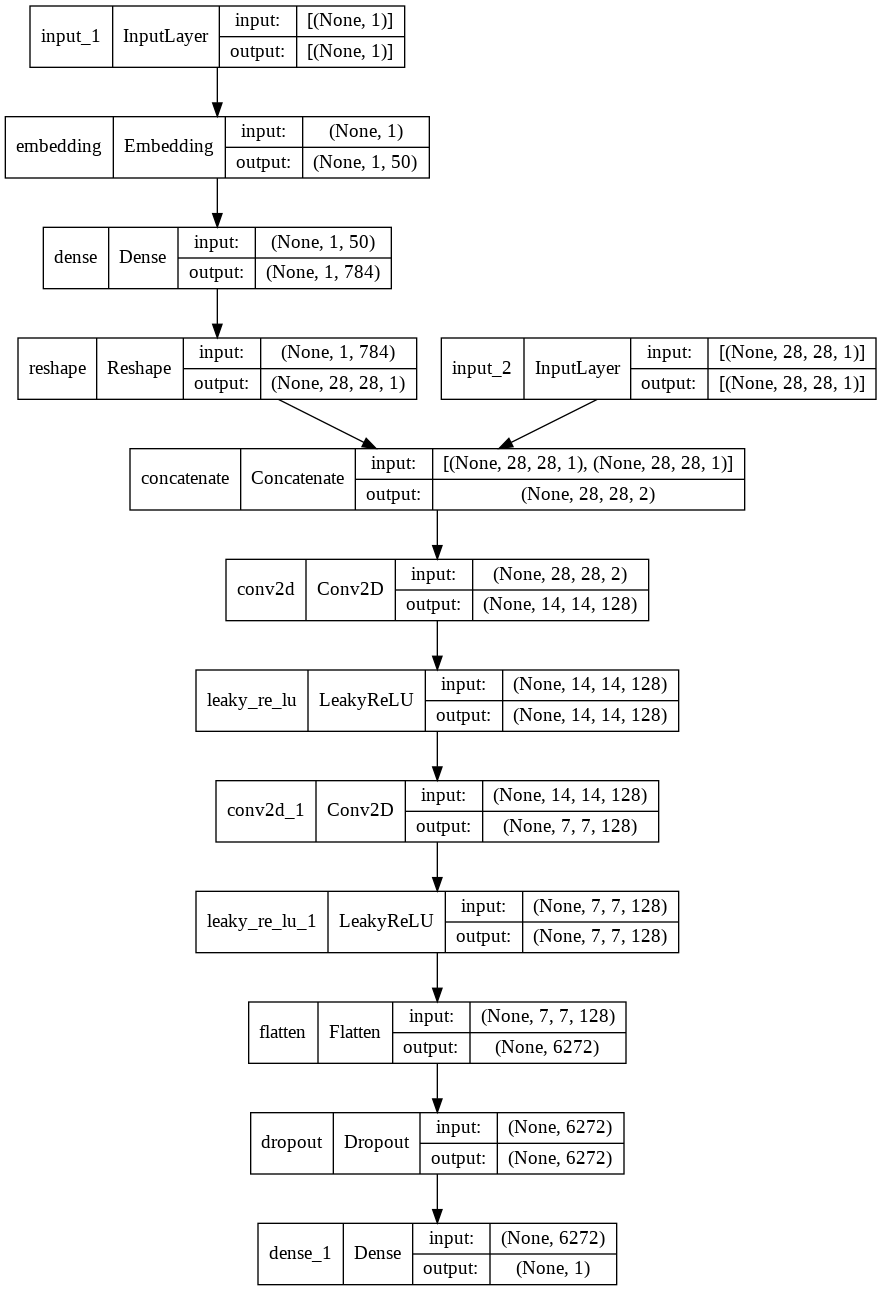

In [3]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [4]:
def define_generator(latent_dim, n_classes=10):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	li = Reshape((7, 7, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	model = Model([in_lat, in_label], out_layer)
	return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

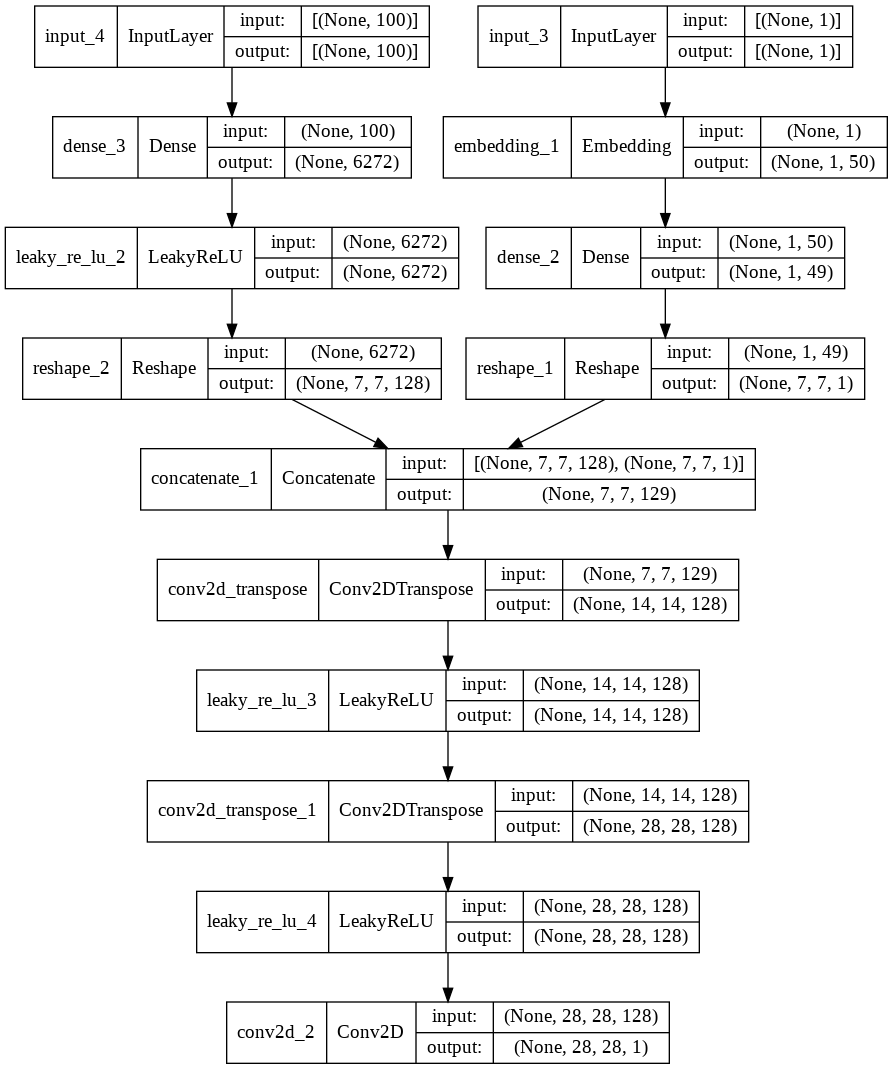

In [5]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [6]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

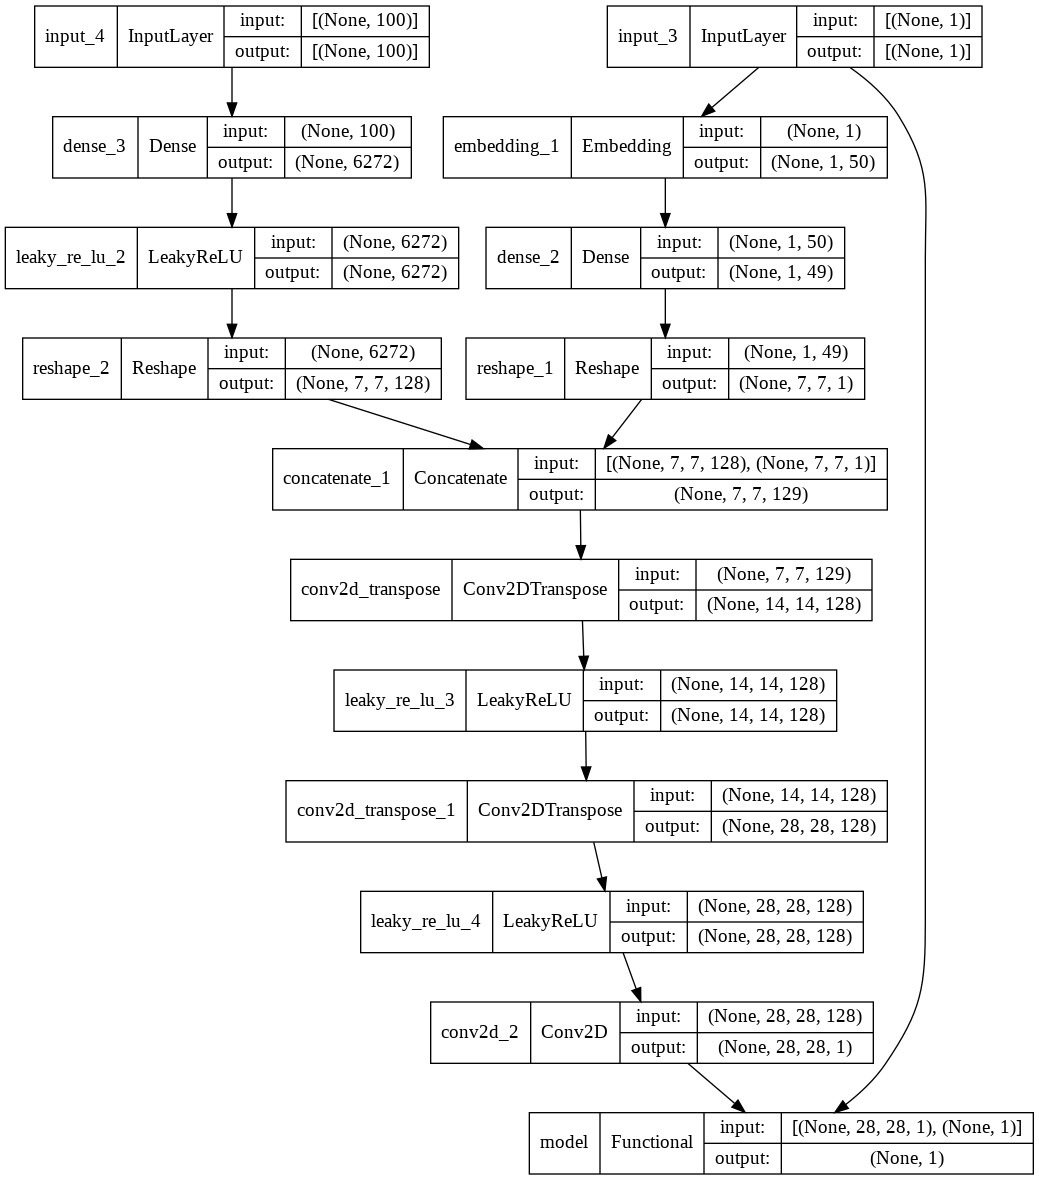

In [7]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [8]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return [X, trainy]

def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [9]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d' % (n_epochs, n_batch, half_batch, bat_per_epo))
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      if (j+1)/bat_per_epo in (1/bat_per_epo, 1/2, 1):
        print('> Epoch %d, batch %d/%d: d_loss1=%.3f, d_loss2=%.3f, g_loss=%.3f' % 
              (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  g_model.save('cgan_generator.h5')

In [12]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

In [13]:
dataset = load_real_samples()

In [14]:
train(g_model, d_model, gan_model, dataset, latent_dim)

n_epochs=100, n_batch=128, 1/2=64, b/e=468
> Epoch 1, batch 1/468: d_loss1=0.717, d_loss2=0.696, g_loss=0.691
> Epoch 1, batch 234/468: d_loss1=0.756, d_loss2=0.650, g_loss=0.801
> Epoch 1, batch 468/468: d_loss1=0.681, d_loss2=0.677, g_loss=0.755
> Epoch 2, batch 1/468: d_loss1=0.686, d_loss2=0.682, g_loss=0.754
> Epoch 2, batch 234/468: d_loss1=0.580, d_loss2=0.638, g_loss=0.864
> Epoch 2, batch 468/468: d_loss1=0.640, d_loss2=0.701, g_loss=0.795
> Epoch 3, batch 1/468: d_loss1=0.679, d_loss2=0.658, g_loss=0.762
> Epoch 3, batch 234/468: d_loss1=0.652, d_loss2=0.636, g_loss=0.773
> Epoch 3, batch 468/468: d_loss1=0.640, d_loss2=0.643, g_loss=0.792
> Epoch 4, batch 1/468: d_loss1=0.656, d_loss2=0.671, g_loss=0.785
> Epoch 4, batch 234/468: d_loss1=0.650, d_loss2=0.645, g_loss=0.801
> Epoch 4, batch 468/468: d_loss1=0.701, d_loss2=0.665, g_loss=0.796
> Epoch 5, batch 1/468: d_loss1=0.674, d_loss2=0.655, g_loss=0.815
> Epoch 5, batch 234/468: d_loss1=0.622, d_loss2=0.662, g_loss=0.831
>

In [15]:
def save_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

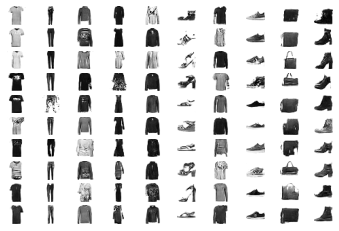

In [16]:
model = load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 10)